In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import measure

In [2]:
# from imutils
# https://github.com/jrosebr1/imutils/blob/master/imutils/convenience.py
def grab_contours(cnts):
    # if the length the contours tuple returned by cv2.findContours
    # is '2' then we are using either OpenCV v2.4, v4-beta, or
    # v4-official
    if len(cnts) == 2:
        cnts = cnts[0]

    # if the length of the contours tuple is '3' then we are using
    # either OpenCV v3, v4-pre, or v4-alpha
    elif len(cnts) == 3:
        cnts = cnts[1]

    # otherwise OpenCV has changed their cv2.findContours return
    # signature yet again and I have no idea WTH is going on
    else:
        raise Exception(("Contours tuple must have length 2 or 3, "
            "otherwise OpenCV changed their cv2.findContours return "
            "signature yet again. Refer to OpenCV's documentation "
            "in that case"))

    # return the actual contours array
    return cnts

In [3]:
# find over-exposed areas
# returns the list of blobs, mask

def find_blobs(input_image):
    # Gaussian blur
    blr = cv2.GaussianBlur(input_image,(5,5),cv2.BORDER_DEFAULT)

    # threshold
    th = cv2.threshold(blr, 235, 255, cv2.THRESH_BINARY)[1] # cv2.threshold gives 2 outputs, ret & th
                                                            # select the 2nd one
    # perform erosions and dilations to remove blobs of noise from image
    th = cv2.erode(th, None, iterations=2)
    th = cv2.dilate(th, None, iterations=4)
   
    # perform connected component analysis on thresholded image
    labels = measure.label(th, neighbors=8, background=0)
    
    # initialize a mask to store only the large components
    mask = np.zeros(th.shape, dtype='uint8')
    
    # loop over unique components
    blobList = [0]
    for label in np.unique(labels):
        #ignore the background label
        if label ==0: #ignore background label
            continue
            
        # construct label mask for current label
        labelMask = np.zeros(th.shape, dtype='uint8')
        labelMask[labels == label] = 255
        
        # count the # of non-zero pixels 
        numPixels = cv2.countNonZero(labelMask)
    
        # if # of pixels in the component is greater than a threshold (300),
        # then add it to the overall mask
        if numPixels > 1000:
            mask = cv2.add(mask, labelMask)
            blobList.append(label)
    return blobList, mask

In [4]:
# find over-exposed areas, then draws circle on the image
# returns the resulting figure, mask

def findNdraw_blobs(input_image):
    # Gaussian blur
    blr = cv2.GaussianBlur(input_image,(5,5),cv2.BORDER_DEFAULT)

    # threshold
    th = cv2.threshold(blr, 235, 255, cv2.THRESH_BINARY)[1] # cv2.threshold gives 2 outputs, ret & th
                                                            # select the 2nd one
    # perform erosions and dilations to remove blobs of noise from image
    th = cv2.erode(th, None, iterations=2)
    th = cv2.dilate(th, None, iterations=4)
   
    # perform connected component analysis on thresholded image
    labels = measure.label(th, neighbors=8, background=0)
    
    # initialize a mask to store only the large components
    mask = np.zeros(th.shape, dtype='uint8')
    
    # loop over unique components
    blobList = [0]
    for label in np.unique(labels):
        #ignore the background label
        if label ==0: #ignore background label
            continue
            
        # construct label mask for current label
        labelMask = np.zeros(th.shape, dtype='uint8')
        labelMask[labels == label] = 255
        
        # count the # of non-zero pixels 
        numPixels = cv2.countNonZero(labelMask)
    
        # if # of pixels in the component is greater than a threshold,
        # then add it to the overall mask
        if numPixels > 1000:
            mask = cv2.add(mask, labelMask)
            blobList.append(label)

    # find the contours in the mask
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = grab_contours(cnts)

    # plot the image
    from matplotlib.patches import Circle
    fig,ax = plt.subplots(1, figsize=(8,8))
    ax.imshow(input_image, 'gray')
    ax.axis('off') # turn off x and y ticks
    # add the number of blobs to image (ax.text(x,y...))
    ax.text(20, 60, "number of blobs = {}".format(len(blobList)-1), color='white', fontsize=14)
        
    # now loop over the contours to draw circles
    for (i, c) in enumerate(cnts):
        # compute the min enclosing circle
        ((cX, cY), radius) = cv2.minEnclosingCircle(c)
        circ = Circle((cX,cY), radius, color='r', linewidth=1, fill=False)
        ax.add_patch(circ)
        ax.annotate(numPixels, xy=(cX+5, cY+5), color='white', fontsize=10) # annotate circles w/ numPixels
    return fig

In [5]:
def show_images(list_of_images, list_of_titles):
    fig = plt.figure(figsize=(10,10), dpi=100)
    images = list_of_images
    titles = list_of_titles
    n = len(list_of_images)

    for i in range(n):
        plt.subplot(n,1,i+1)
        plt.imshow(images[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([]) #hide ticks

    plt.show()
    plt.close(fig)

In [6]:
# function to blur out blobs
def blur_blobs(input_image, input_mask):
    blr = cv2.GaussianBlur(input_image, (101, 101), 0) # blur image
    dilatedMask = cv2.dilate(mask, None, iterations=25)
    output_image = np.where(dilatedMask, blr, input_image) # mask over original image with blurred
    return output_image

In [95]:
image = cv2.imread("Images/blob_test/676.43_MFGTMP_191024160002_A02f222d2.TIF", 0)

In [104]:
# create mask on over-exposed parts
blobList, mask = find_blobs(image)
# invert mask
invertedMask = cv2.bitwise_not(mask)
# mask over original
maskedImg = cv2.bitwise_and(src1 = image, src2 = invertedMask)
# edges
edges = cv2.Canny(maskedImg, 100, 200)

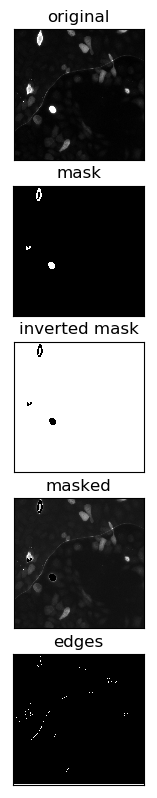

In [107]:
show_images([image, mask, inverted, maskedImg, edges], 
            ['original', 'mask', 'inverted mask', 'masked', 'edges'])

In [49]:
# find eoverexposed cells, circle them, and write how many pixels are in them
# to test and adjust blob detection threshold
file_path = "Images/blob_test/"

for entry in os.scandir(file_path):
    if entry.name.endswith('.tif') or entry.name.endswith('.TIF'): #check file type
        print(entry.name)
        image = cv2.imread(entry.path,0)
        blobList, mask = find_blobs(image)
        fig = findNdraw_blobs(image)

        #save the image
        plt.savefig(file_path + "circled/" + entry.name, dpi=100, bbox_inches='tight')
        plt.close()

771.81_MFGTMP_191024160002_A02f231d2.TIF
429.25_MFGTMP_191024160002_A02f235d2.TIF
670.73_MFGTMP_191024160002_A02f295d2.TIF
MFGTMP_191024160001_A02f78d2.TIF
411.76_MFGTMP_191024160002_A02f312d2.TIF
676.43_MFGTMP_191024160002_A02f222d2.TIF
659.63_MFGTMP_191024160002_A02f220d2.TIF
330.65_MFGTMP_191024160001_A02f43d2.TIF
509.81_MFGTMP_191024160002_A02f285d2.TIF
MFGTMP_191024160001_A02f56d2.TIF
MFGTMP_191024160001_A02f52d2.TIF
687.60_MFGTMP_191024160002_A02f232d2.TIF
MFGTMP_191024160001_A02f50d2.TIF
517.19_MFGTMP_191024160002_A02f233d2.TIF
MFGTMP_191024160001_A02f48d2.TIF
759.53_MFGTMP_191024160001_A02f117d2.TIF
636.62_MFGTMP_191024160002_A02f240d2.TIF


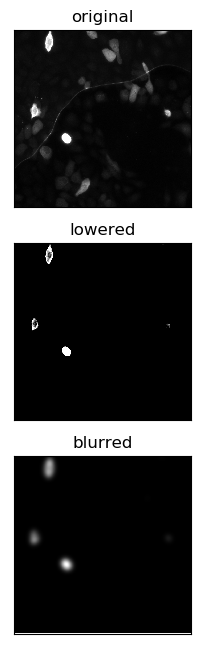

In [85]:
# let's try to decrease brightness
image = cv2.imread("Images/blob_test/676.43_MFGTMP_191024160002_A02f222d2.TIF",0)
# adjust contrast (alpha) and brightness (beta)
# g(x)=αf(x)+β; gain/ bias, or contrast/ brightness
new_image = np.clip(0.5*image -90, 0, 255)
blr = cv2.GaussianBlur(new_image, (101, 101), 0)

show_images([image, new_image, blr], ['original', 'lowered', 'blurred'])

In [7]:
def variance_of_laplacian(image):
# compute the Laplacian of the image and then return the focus
# measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

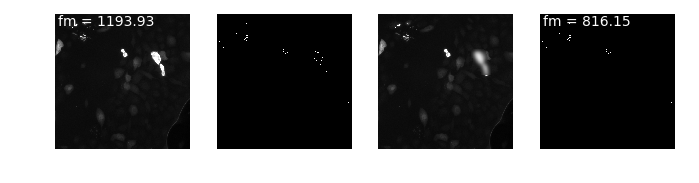

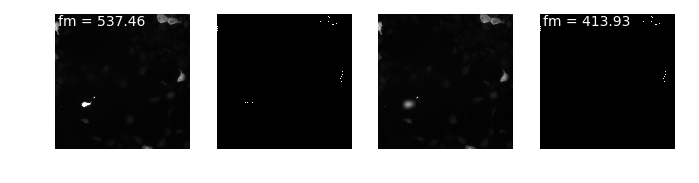

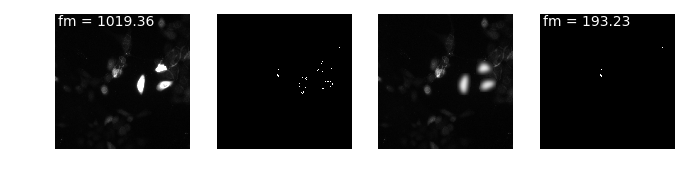

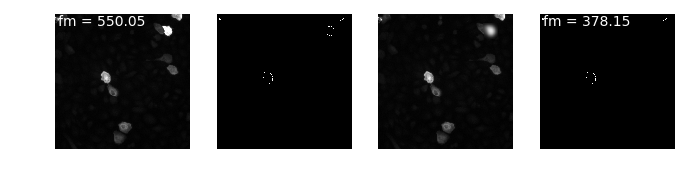

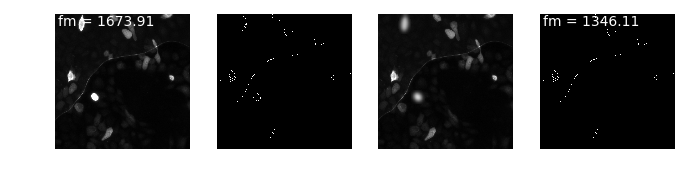

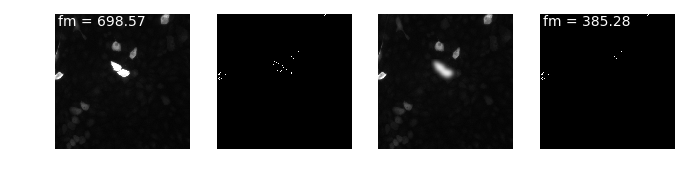

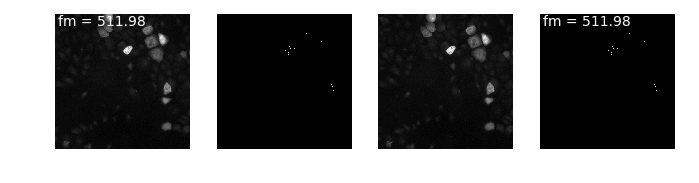

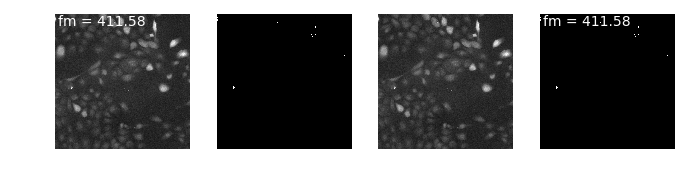

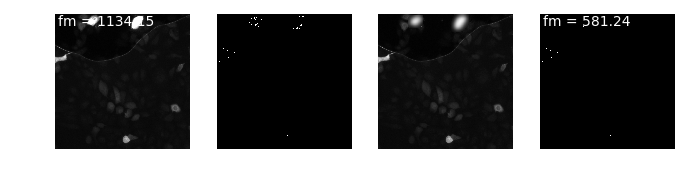

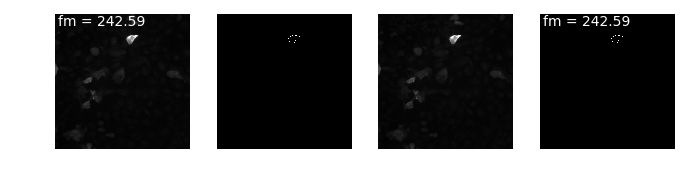

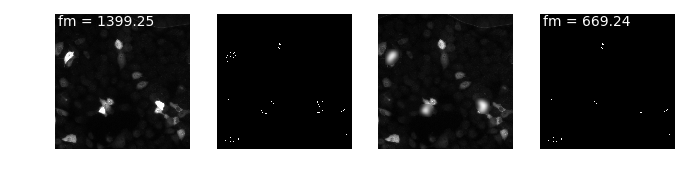

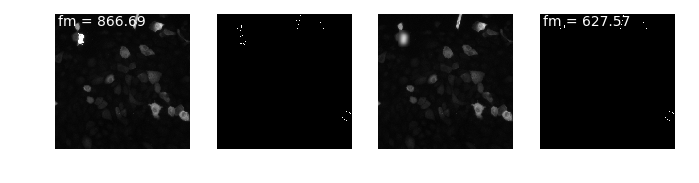

In [9]:
# blur over-exposed parts from image
# then find edges
file_path = "Images/blob_test/"

for entry in os.scandir(file_path):
    if entry.name.endswith('.tif') or entry.name.endswith('.TIF'): #check file type
        image = cv2.imread(entry.path,0)
        blobList, mask = find_blobs(image) # create mask
        blrred = blur_blobs(image, mask)
        
        edgesBefore = cv2.Canny(image, 100, 200) # Canny edge detection
        edgesAfter = cv2.Canny(blrred, 100, 200)
        fmBefore = variance_of_laplacian(edgesBefore)# calculate focus measure (fm)
        fmAfter = variance_of_laplacian(edgesAfter)
        valueBefore = "{:.2f}".format(fmBefore)
        valueAfter = "{:.2f}".format(fmAfter)
    
        # show and save the image
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(8,8), dpi=100)
        ax1.imshow(image, 'gray')
        ax1.text(20, 80, "fm = {}".format(valueBefore), color='white', fontsize=10)
        ax1.axis('off')
        
        ax2.imshow(edgesBefore, 'gray')
        ax2.axis('off')
        
        ax3.imshow(blrred, 'gray')
        ax3.axis('off')
        
        ax4.imshow(edgesAfter, 'gray')
        ax4.text(20, 80, "fm = {}".format(valueAfter), color='white', fontsize=10)
        ax4.axis('off')
        
        #ax.text(20, 60, "fm = {}".format(value), color='white', fontsize=14)
        #plt.savefig(file_path + 'edges_' + entry.name, dpi=100, bbox_inches='tight')
        plt.show()
        plt.close()

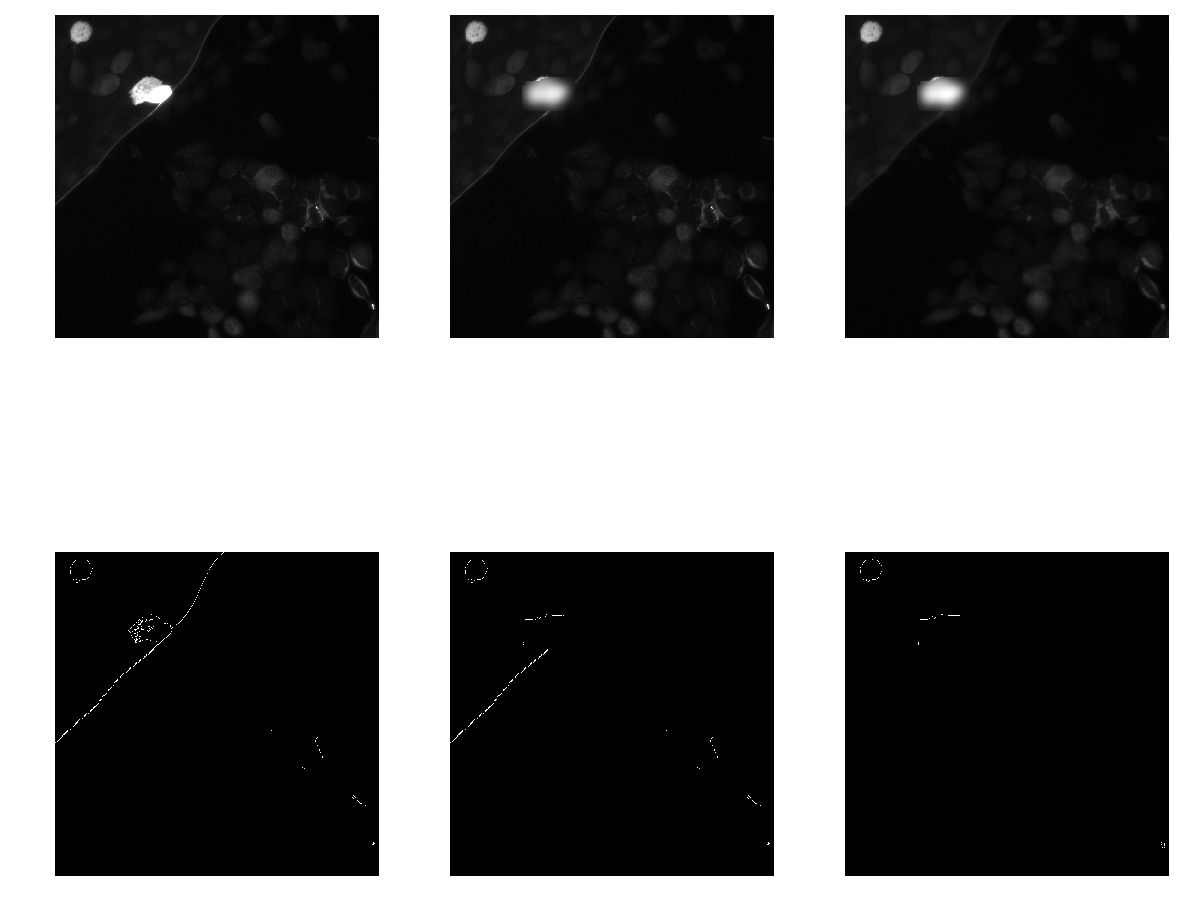

In [144]:
# load image, blur over-exposed cells, remove air bubbles
image = cv2.imread("Images/Y180H/MFGTMP_191024160002_A02f296d2.TIF",0)
edge1 = cv2.Canny(image, 50, 200)

# blur out blobs
blobList, mask = find_blobs(image) # create mask
blrred = blur_blobs(image, mask)
edge2 = cv2.Canny(blrred, 50, 200)

# morphological transform
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(7,5))
morph = cv2.morphologyEx(blrred, cv2.MORPH_OPEN, kernel)
edge3 = cv2.Canny(morph, 50, 200)

# show the images
fig, axs = plt.subplots(2, 3, figsize=(12,12), dpi=100)

axs[0,0].imshow(image, 'gray')
#axs.axis('off')
        
axs[0,1].imshow(blrred, 'gray')
#ax2.axis('off')
        
axs[0,2].imshow(morph, 'gray')
#ax3.axis('off')

axs[1,0].imshow(edge1, 'gray')
#ax4.axis('off')
axs[1,1].imshow(edge2, 'gray')
#ax5.axis('off')
axs[1,2].imshow(edge3, 'gray')
#ax6.axis('off')

for ax in axs.flat:
    ax.axis('off')
plt.tight_layout()
plt.show()
plt.close()